In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [2]:

from flax import nnx
import jax
from jax._src.tree_util import tree_structure
import jax.numpy as jnp
from jaxtyping import Array

In [3]:
from architectures.node import NeuralODE
from architectures.utils_node import eval_model
from architectures.architectures import MLP,ResNet
from geometry.G_matrix import G_matrix
from functionals.functions import create_potentials
from functionals.linear_funcitonal_class import LinearPotential
from functionals.functions import zero_potential_fn
from functionals.internal_functional_class import InternalPotential
from functionals.interaction_functional_class import InteractionPotential
from functionals.functional import Potential
from flows.hamiltonian_flow_step import hamiltonian_flow_step
from flows.hamiltonian_flow import initialize_momentum, run_hamiltonian_flow
from parametric_model.parametric_model import ParametricModel


In [4]:
device = 0

In [21]:
# Define the parametric model
parametric_model = ParametricModel(
    parametric_map="mlp", # "node" "resnet"
    architecture=[2, 0, 2], # [input_dim, num_layers, hidden_width]
    activation_fn="identity", # "tanh", "relu", "SinTu", "identity"
    time_dependent=True,    # True or False
    solver="euler", # "euler" or "heun"
    dt0=0.1,
    rhs_model="mlp", # "mlp" or "resnet"
    ref_density="gaussian",
    scale_factor=1e-6
)

In [22]:
_, initial_params = nnx.split(parametric_model)

In [23]:
def phi_fn(t: float,x: Array) -> Array:
    ''' phi(t,x) = -x[0]^2/2 '''
    return -x[:,0]**2/2

In [24]:
n_samples = 2_000  # Monte Carlo sample size
key = jax.random.PRNGKey(1234)
rngs = nnx.Rngs(key)
# Generate reference samples from lambda = N(0, I)
key, subkey = jax.random.split(key)
test_data_set = jax.random.normal(subkey, (n_samples, 2))
G_mat = G_matrix(parametric_model)

In [25]:
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))
p = initialize_momentum(parametric_model = parametric_model,z_samples=z_samples,phi_fn=phi_fn)

In [26]:
zero_potential = LinearPotential(zero_potential_fn)
potential = Potential(zero_potential)

# Initialize the variable for a Hamiltonian step

In [29]:
step_size = 5e-2
solver = 'cg'
gamma = 1e-2

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Initial Hamiltonian: 0.600745


Hamiltonian Flow Progress:   1%|          | 1/99 [00:00<00:54,  1.81it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.057101]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846


Hamiltonian Flow Progress:   2%|▏         | 2/99 [00:01<00:54,  1.79it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054230]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846


Hamiltonian Flow Progress:   3%|▎         | 3/99 [00:01<00:53,  1.81it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053411]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846


Hamiltonian Flow Progress:   4%|▍         | 4/99 [00:02<00:52,  1.80it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.052717]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846


Hamiltonian Flow Progress:   5%|▌         | 5/99 [00:02<00:52,  1.80it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053721]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846


Hamiltonian Flow Progress:   5%|▌         | 5/99 [00:03<00:52,  1.80it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055393]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-5.7790801e-03,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[6.7363286e-01, 6.2480410e-07],
                 [5.5211652e-03, 9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter   5: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.59e-01


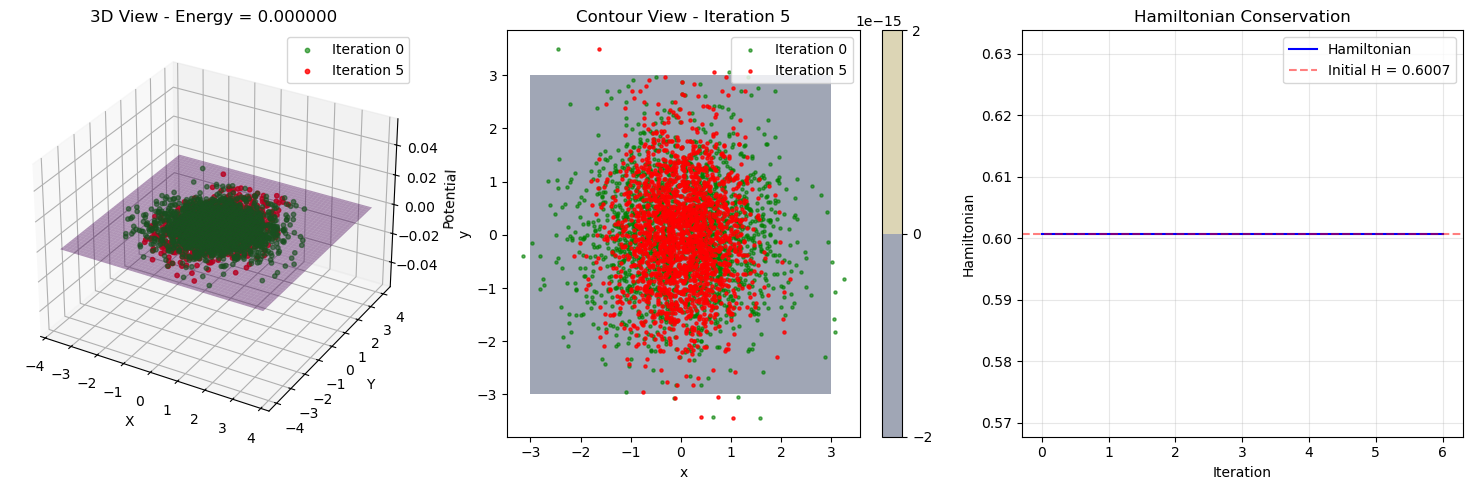

Hamiltonian Flow Progress:   7%|▋         | 7/99 [00:04<01:12,  1.27it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054329]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 6


Hamiltonian Flow Progress:   8%|▊         | 8/99 [00:05<01:04,  1.41it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.052175]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 7


Hamiltonian Flow Progress:   9%|▉         | 9/99 [00:05<00:59,  1.52it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053793]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 8


Hamiltonian Flow Progress:  10%|█         | 10/99 [00:06<00:55,  1.60it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053456]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 9


Hamiltonian Flow Progress:  10%|█         | 10/99 [00:07<00:55,  1.60it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054605]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-1.0665657e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[4.0549940e-01, 6.2480410e-07],
                 [1.3217242e-02, 9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  10: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.13e-01


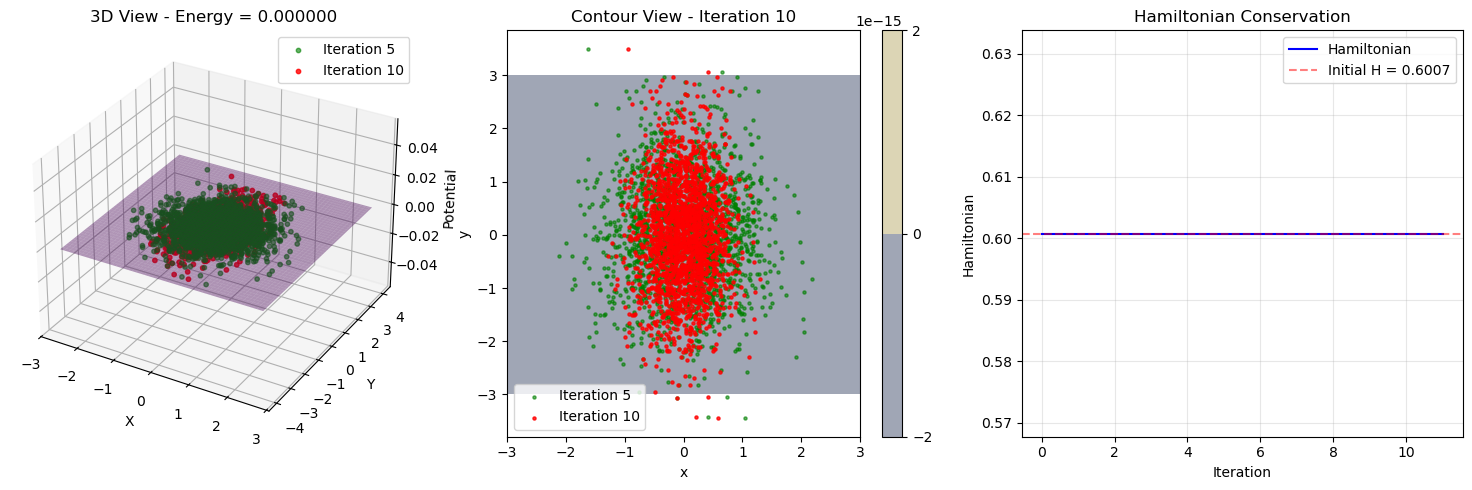

Hamiltonian Flow Progress:  11%|█         | 11/99 [00:08<01:19,  1.10it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054605]

Excellent Hamiltonian conservation at iteration 10


Hamiltonian Flow Progress:  12%|█▏        | 12/99 [00:08<01:09,  1.25it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054009]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 11


Hamiltonian Flow Progress:  13%|█▎        | 13/99 [00:09<01:02,  1.38it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053762]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 12


Hamiltonian Flow Progress:  14%|█▍        | 14/99 [00:09<00:57,  1.49it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.056659]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 13


Hamiltonian Flow Progress:  15%|█▌        | 15/99 [00:10<00:53,  1.58it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055966]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 14


Hamiltonian Flow Progress:  15%|█▌        | 15/99 [00:10<00:53,  1.58it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054094]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-1.4315944e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[1.3136506e-01, 6.2480410e-07],
                 [2.5113676e-02, 9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  15: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.18e-01


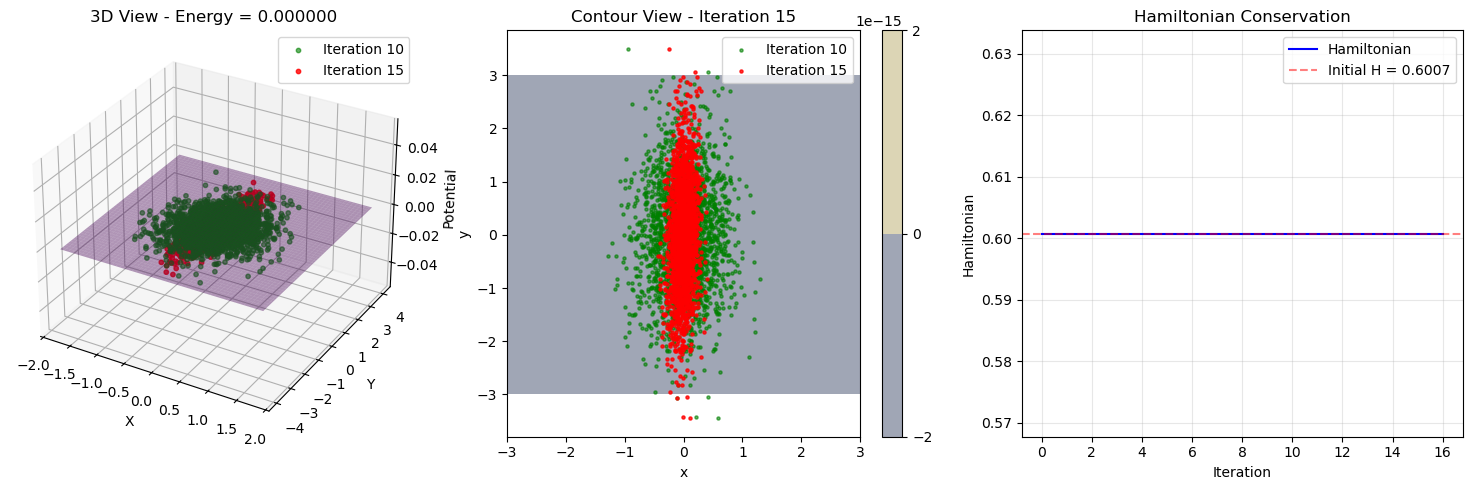

Hamiltonian Flow Progress:  16%|█▌        | 16/99 [00:11<01:14,  1.11it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054094]

Excellent Hamiltonian conservation at iteration 15


Hamiltonian Flow Progress:  17%|█▋        | 17/99 [00:12<01:05,  1.25it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.052274]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 16


Hamiltonian Flow Progress:  18%|█▊        | 18/99 [00:12<00:58,  1.38it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054804]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 17


Hamiltonian Flow Progress:  19%|█▉        | 19/99 [00:13<00:53,  1.49it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.052549]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 18


Hamiltonian Flow Progress:  20%|██        | 20/99 [00:14<00:50,  1.58it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054157]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 19


Hamiltonian Flow Progress:  20%|██        | 20/99 [00:14<00:50,  1.58it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055281]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-2.0341482e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-1.3710772e-01,  6.2480410e-07],
                 [ 4.0802371e-02,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  20: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.14e-01


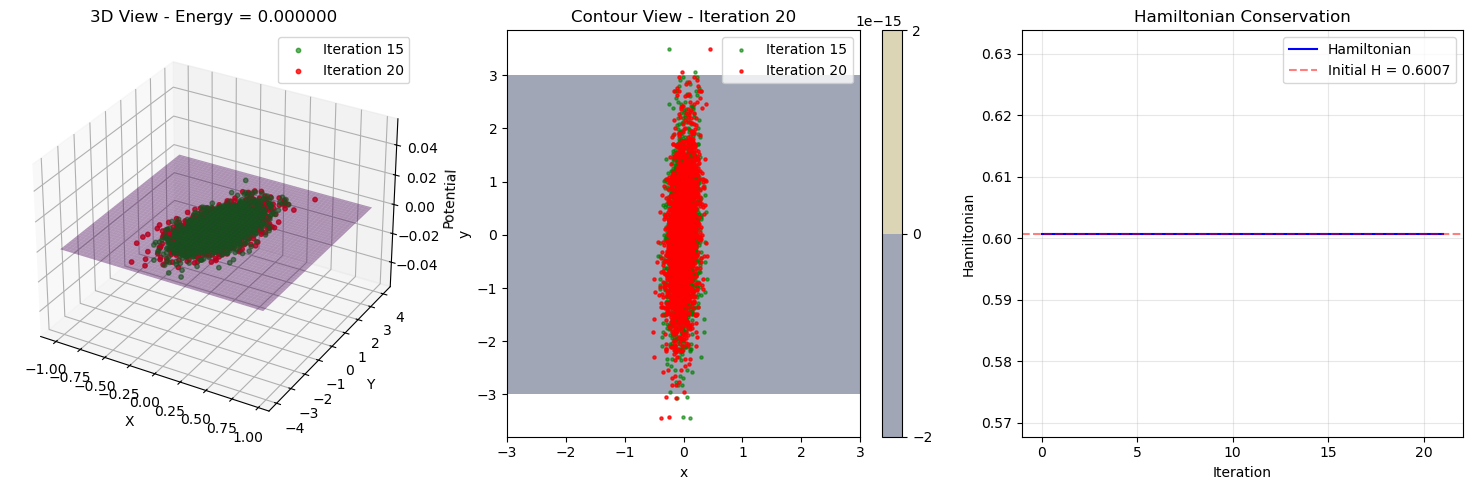

Hamiltonian Flow Progress:  21%|██        | 21/99 [00:16<01:23,  1.07s/it, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055281]

Excellent Hamiltonian conservation at iteration 20


Hamiltonian Flow Progress:  22%|██▏       | 22/99 [00:16<01:10,  1.09it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053157]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 21


Hamiltonian Flow Progress:  23%|██▎       | 23/99 [00:17<01:01,  1.23it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055174]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 22


Hamiltonian Flow Progress:  24%|██▍       | 24/99 [00:17<00:54,  1.36it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055932]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 23


Hamiltonian Flow Progress:  25%|██▌       | 25/99 [00:18<00:50,  1.47it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053416]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 24


Hamiltonian Flow Progress:  25%|██▌       | 25/99 [00:18<00:50,  1.47it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054455]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-2.3815185e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-4.0894768e-01,  6.2480410e-07],
                 [ 5.1190313e-02,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  25: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.16e-01


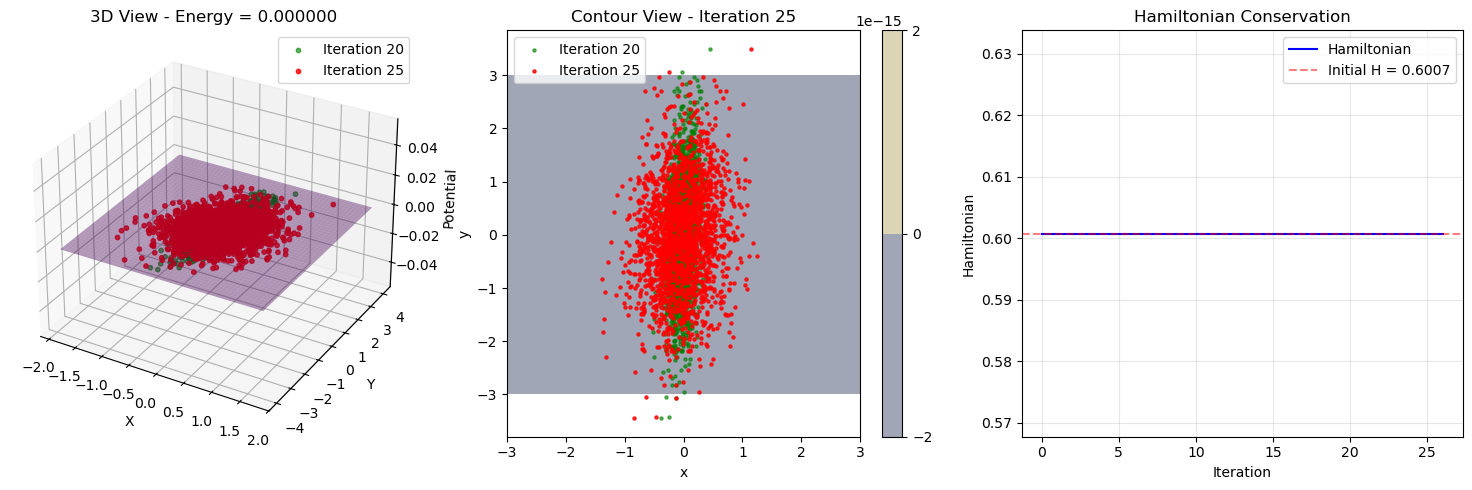

Hamiltonian Flow Progress:  26%|██▋       | 26/99 [00:19<01:07,  1.07it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054455]

Excellent Hamiltonian conservation at iteration 25


Hamiltonian Flow Progress:  27%|██▋       | 27/99 [00:20<00:58,  1.22it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.057962]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 26


Hamiltonian Flow Progress:  28%|██▊       | 28/99 [00:20<00:52,  1.36it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.059149]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 27


Hamiltonian Flow Progress:  29%|██▉       | 29/99 [00:21<00:47,  1.47it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054290]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 28


Hamiltonian Flow Progress:  30%|███       | 30/99 [00:22<00:44,  1.56it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.051798]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 29


Hamiltonian Flow Progress:  30%|███       | 30/99 [00:22<00:44,  1.56it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.050438]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-2.9468041e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-6.8223053e-01,  6.2480410e-07],
                 [ 5.8005270e-02,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  30: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.17e-01


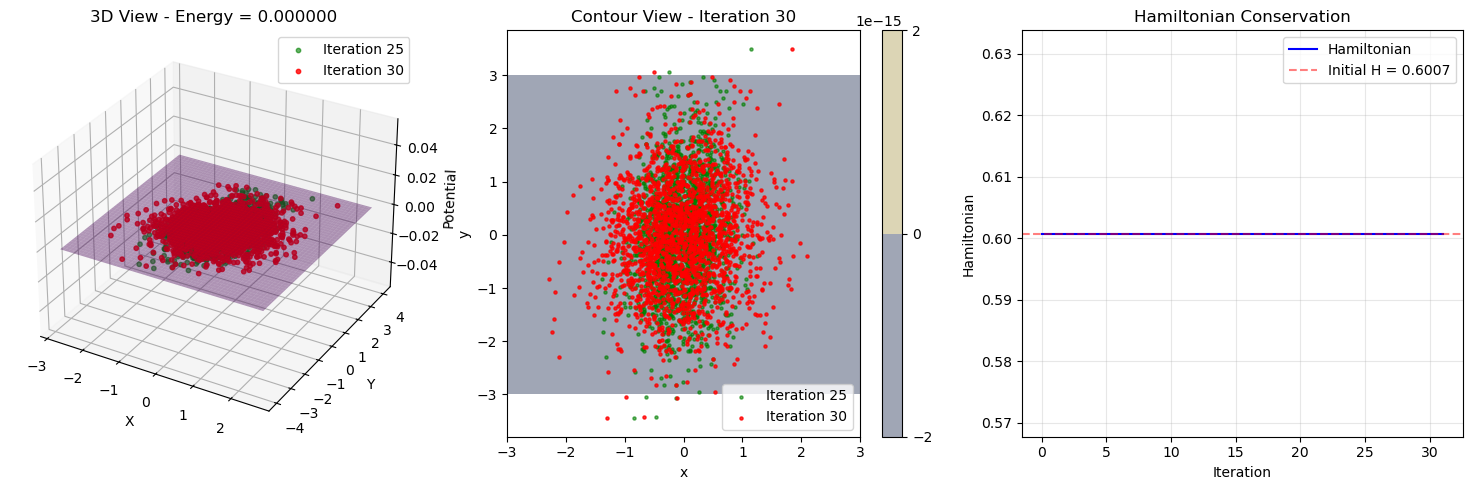

Hamiltonian Flow Progress:  31%|███▏      | 31/99 [00:23<01:01,  1.10it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.050438]

Excellent Hamiltonian conservation at iteration 30


Hamiltonian Flow Progress:  32%|███▏      | 32/99 [00:24<00:53,  1.24it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.056151]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 31


Hamiltonian Flow Progress:  33%|███▎      | 33/99 [00:24<00:48,  1.37it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.056788]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 32


Hamiltonian Flow Progress:  34%|███▍      | 34/99 [00:25<00:44,  1.48it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.057089]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 33


Hamiltonian Flow Progress:  35%|███▌      | 35/99 [00:25<00:40,  1.57it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054263]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 34


Hamiltonian Flow Progress:  35%|███▌      | 35/99 [00:26<00:40,  1.57it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054036]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-3.2353729e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-9.6039820e-01,  6.2480410e-07],
                 [ 5.7002276e-02,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  35: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.21e-01


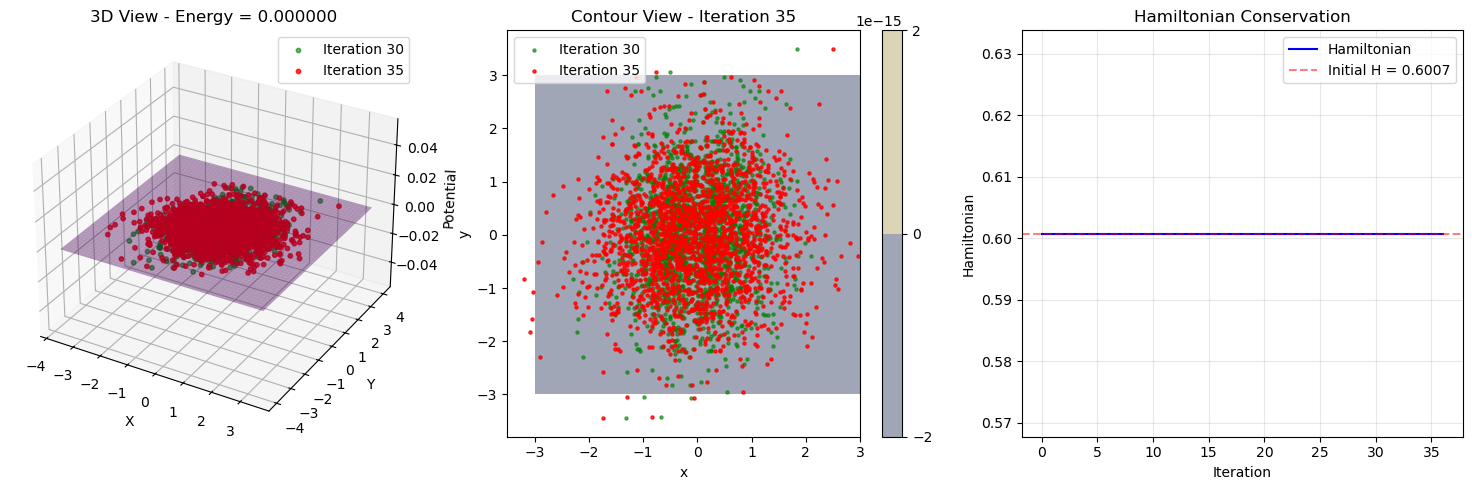

Hamiltonian Flow Progress:  36%|███▋      | 36/99 [00:27<00:57,  1.09it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054036]

Excellent Hamiltonian conservation at iteration 35


Hamiltonian Flow Progress:  37%|███▋      | 37/99 [00:27<00:50,  1.24it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053968]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 36


Hamiltonian Flow Progress:  38%|███▊      | 38/99 [00:28<00:44,  1.37it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053320]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 37


Hamiltonian Flow Progress:  39%|███▉      | 39/99 [00:29<00:40,  1.47it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055304]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 38


Hamiltonian Flow Progress:  40%|████      | 40/99 [00:29<00:37,  1.56it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053677]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 39


Hamiltonian Flow Progress:  40%|████      | 40/99 [00:30<00:37,  1.56it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054601]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-3.8793892e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-1.2308676e+00,  6.2480410e-07],
                 [ 6.8935379e-02,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  40: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.15e-01


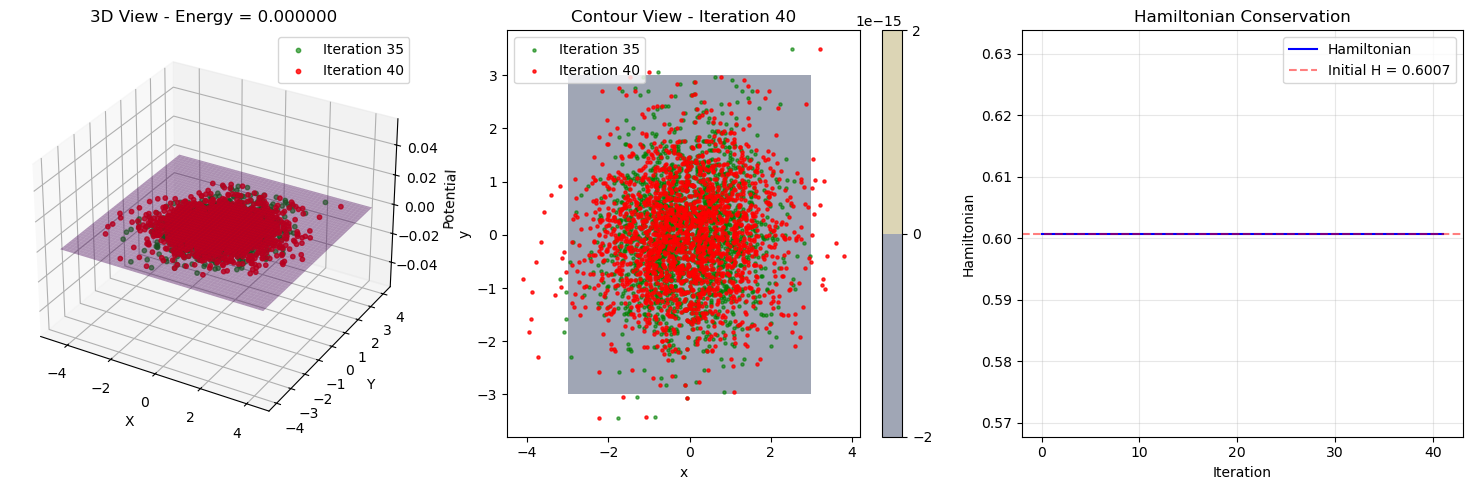

Hamiltonian Flow Progress:  41%|████▏     | 41/99 [00:31<00:52,  1.10it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054601]

Excellent Hamiltonian conservation at iteration 40


Hamiltonian Flow Progress:  42%|████▏     | 42/99 [00:31<00:45,  1.24it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054414]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 41


Hamiltonian Flow Progress:  43%|████▎     | 43/99 [00:32<00:40,  1.37it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054988]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 42


Hamiltonian Flow Progress:  44%|████▍     | 44/99 [00:32<00:37,  1.48it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.051824]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 43


Hamiltonian Flow Progress:  45%|████▌     | 45/99 [00:33<00:34,  1.57it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.050880]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 44


Hamiltonian Flow Progress:  45%|████▌     | 45/99 [00:33<00:34,  1.57it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053753]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-4.2798903e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-1.4964716e+00,  6.2480410e-07],
                 [ 7.6025575e-02,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  45: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.11e-01


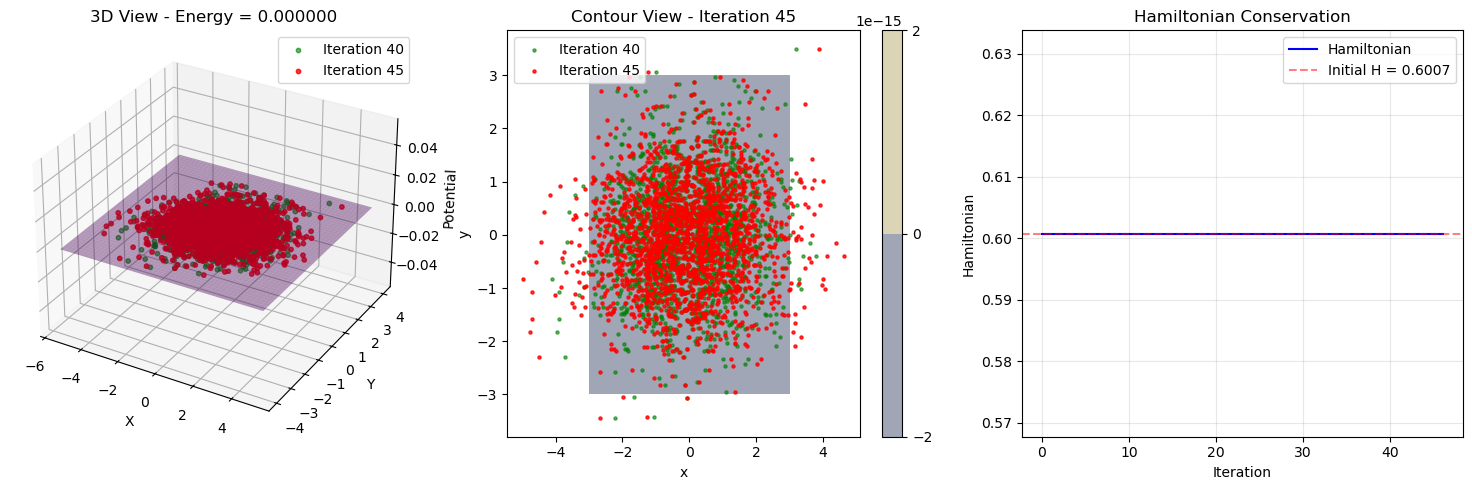

Hamiltonian Flow Progress:  46%|████▋     | 46/99 [00:34<00:48,  1.10it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053753]

Excellent Hamiltonian conservation at iteration 45


Hamiltonian Flow Progress:  47%|████▋     | 47/99 [00:35<00:41,  1.24it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.052431]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 46


Hamiltonian Flow Progress:  48%|████▊     | 48/99 [00:35<00:37,  1.37it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.056516]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 47


Hamiltonian Flow Progress:  49%|████▉     | 49/99 [00:36<00:33,  1.48it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053500]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 48


Hamiltonian Flow Progress:  51%|█████     | 50/99 [00:37<00:31,  1.56it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055103]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 49


Hamiltonian Flow Progress:  51%|█████     | 50/99 [00:37<00:31,  1.56it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053392]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-4.9952127e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-1.7670321e+00,  6.2480410e-07],
                 [ 8.5822731e-02,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  50: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.15e-01


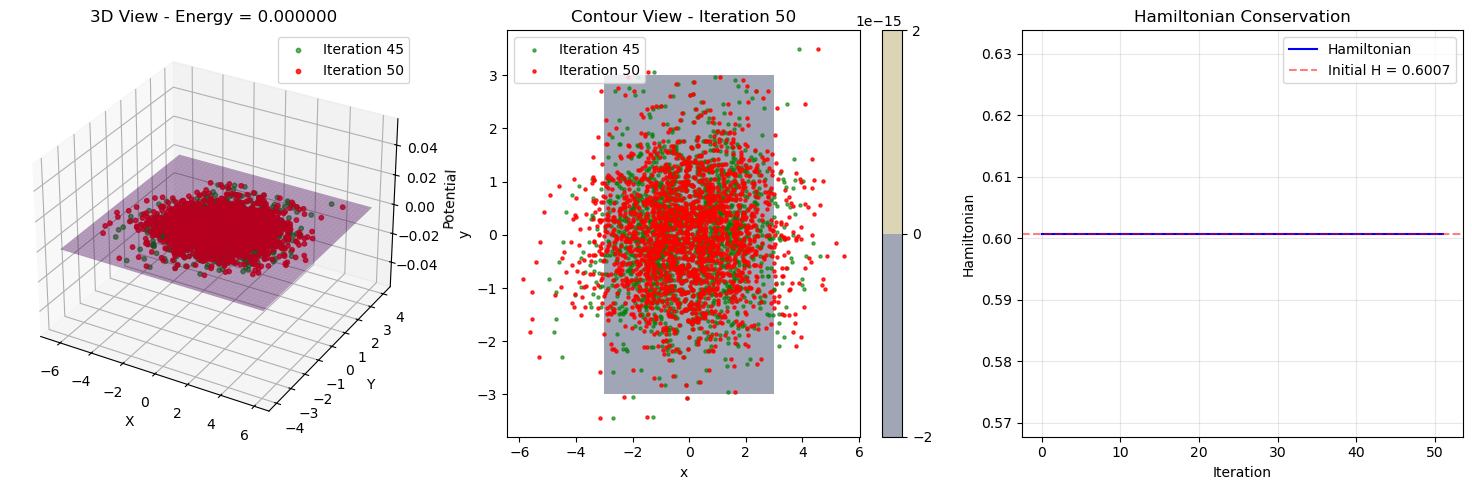

Hamiltonian Flow Progress:  52%|█████▏    | 51/99 [00:38<00:43,  1.09it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053392]

Excellent Hamiltonian conservation at iteration 50


Hamiltonian Flow Progress:  53%|█████▎    | 52/99 [00:39<00:38,  1.23it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055631]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 51


Hamiltonian Flow Progress:  54%|█████▎    | 53/99 [00:39<00:33,  1.36it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055887]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 52


Hamiltonian Flow Progress:  55%|█████▍    | 54/99 [00:40<00:30,  1.47it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053644]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 53


Hamiltonian Flow Progress:  56%|█████▌    | 55/99 [00:40<00:28,  1.56it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054522]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 54


Hamiltonian Flow Progress:  56%|█████▌    | 55/99 [00:41<00:28,  1.56it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053817]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-5.1503565e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-2.0403352e+00,  6.2480410e-07],
                 [ 9.2419535e-02,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  55: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.18e-01


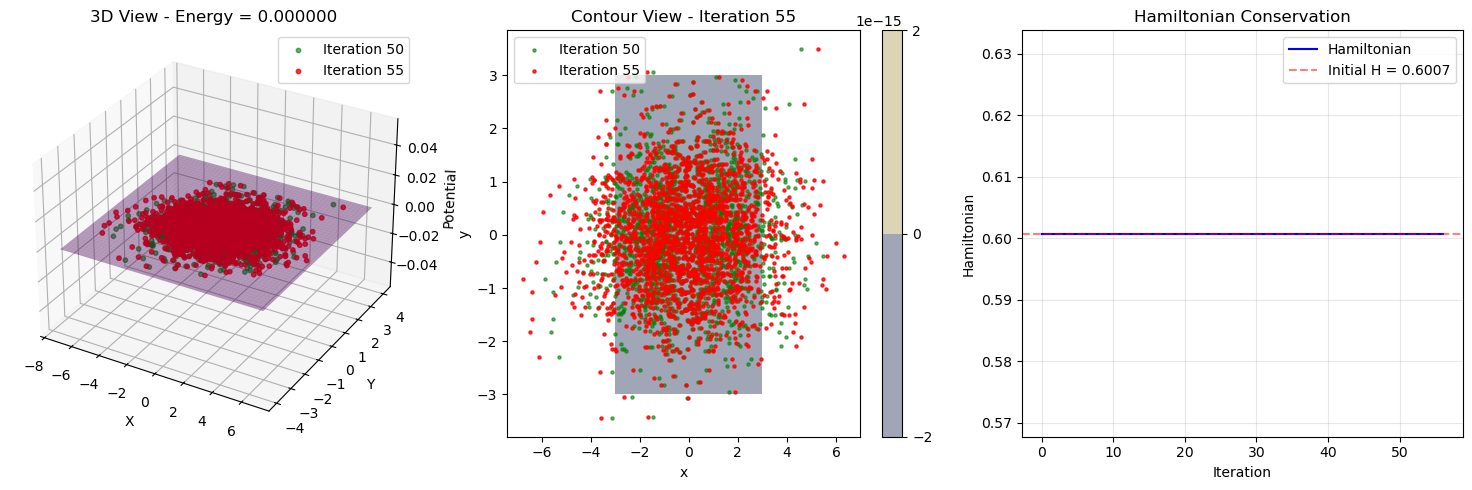

Hamiltonian Flow Progress:  57%|█████▋    | 56/99 [00:42<00:39,  1.09it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053817]

Excellent Hamiltonian conservation at iteration 55


Hamiltonian Flow Progress:  58%|█████▊    | 57/99 [00:43<00:33,  1.24it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.052726]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 56


Hamiltonian Flow Progress:  59%|█████▊    | 58/99 [00:43<00:29,  1.37it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054796]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 57


Hamiltonian Flow Progress:  60%|█████▉    | 59/99 [00:44<00:34,  1.17it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.056328]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 58


Hamiltonian Flow Progress:  61%|██████    | 60/99 [00:45<00:30,  1.29it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.057366]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 59


Hamiltonian Flow Progress:  61%|██████    | 60/99 [00:45<00:30,  1.29it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.051414]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-5.8288500e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-2.3126471e+00,  6.2480410e-07],
                 [ 1.0048902e-01,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  60: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.16e-01


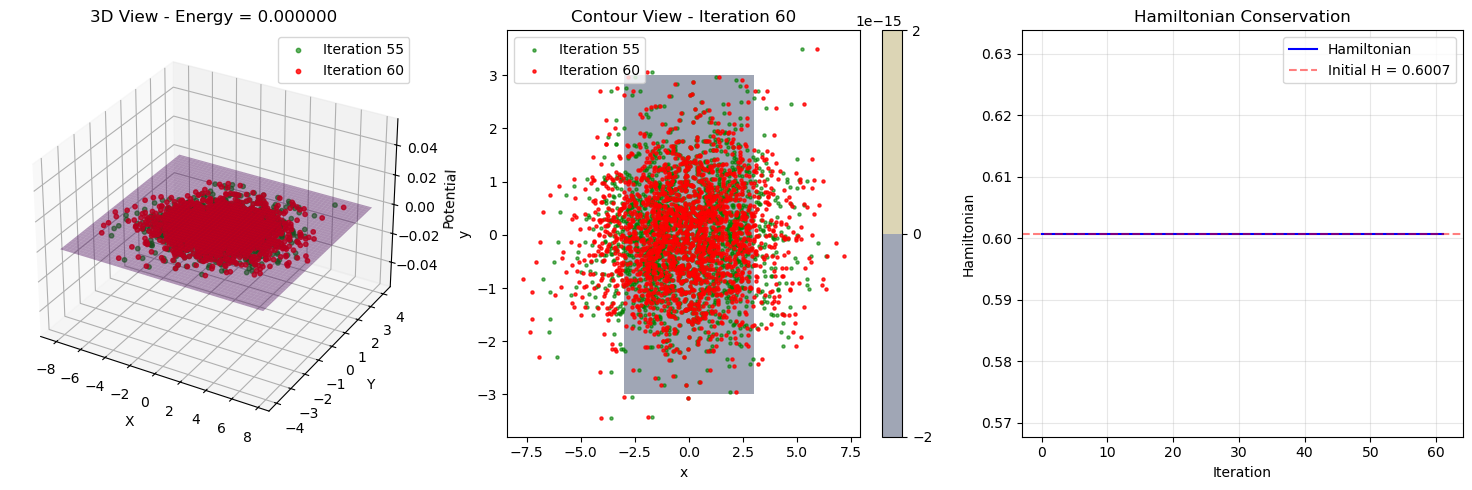

Hamiltonian Flow Progress:  62%|██████▏   | 61/99 [00:46<00:38,  1.01s/it, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.051414]

Excellent Hamiltonian conservation at iteration 60


Hamiltonian Flow Progress:  63%|██████▎   | 62/99 [00:47<00:32,  1.14it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.057944]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 61


Hamiltonian Flow Progress:  64%|██████▎   | 63/99 [00:47<00:28,  1.28it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054166]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 62


Hamiltonian Flow Progress:  65%|██████▍   | 64/99 [00:48<00:25,  1.40it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053954]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 63


Hamiltonian Flow Progress:  66%|██████▌   | 65/99 [00:49<00:22,  1.50it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054760]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 64


Hamiltonian Flow Progress:  66%|██████▌   | 65/99 [00:49<00:22,  1.50it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.056153]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-6.8268031e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-2.58918285e+00,  6.24804102e-07],
                 [ 1.07337266e-01,  9.99999166e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  65: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.21e-01


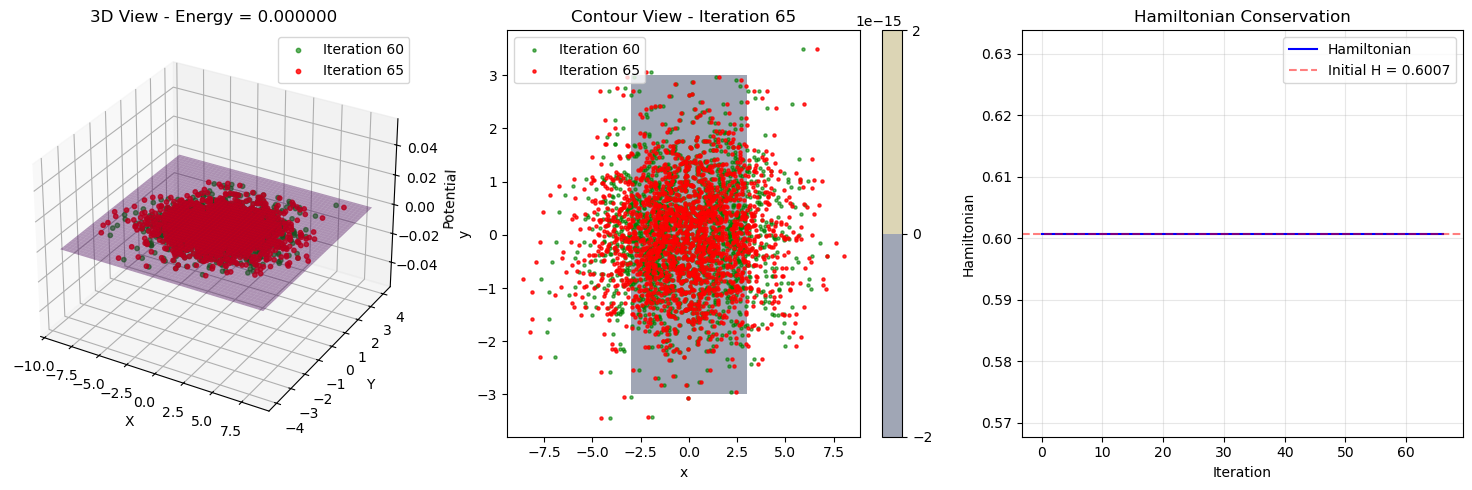

Hamiltonian Flow Progress:  67%|██████▋   | 66/99 [00:50<00:31,  1.06it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.056153]

Excellent Hamiltonian conservation at iteration 65


Hamiltonian Flow Progress:  68%|██████▊   | 67/99 [00:51<00:26,  1.20it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054863]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 66


Hamiltonian Flow Progress:  69%|██████▊   | 68/99 [00:51<00:23,  1.33it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.052394]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 67


Hamiltonian Flow Progress:  70%|██████▉   | 69/99 [00:52<00:20,  1.44it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054747]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 68


Hamiltonian Flow Progress:  71%|███████   | 70/99 [00:52<00:18,  1.53it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.057286]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 69


Hamiltonian Flow Progress:  71%|███████   | 70/99 [00:53<00:18,  1.53it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.051408]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-7.4455231e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-2.85965157e+00,  6.24804102e-07],
                 [ 1.12724505e-01,  9.99999166e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  70: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.14e-01


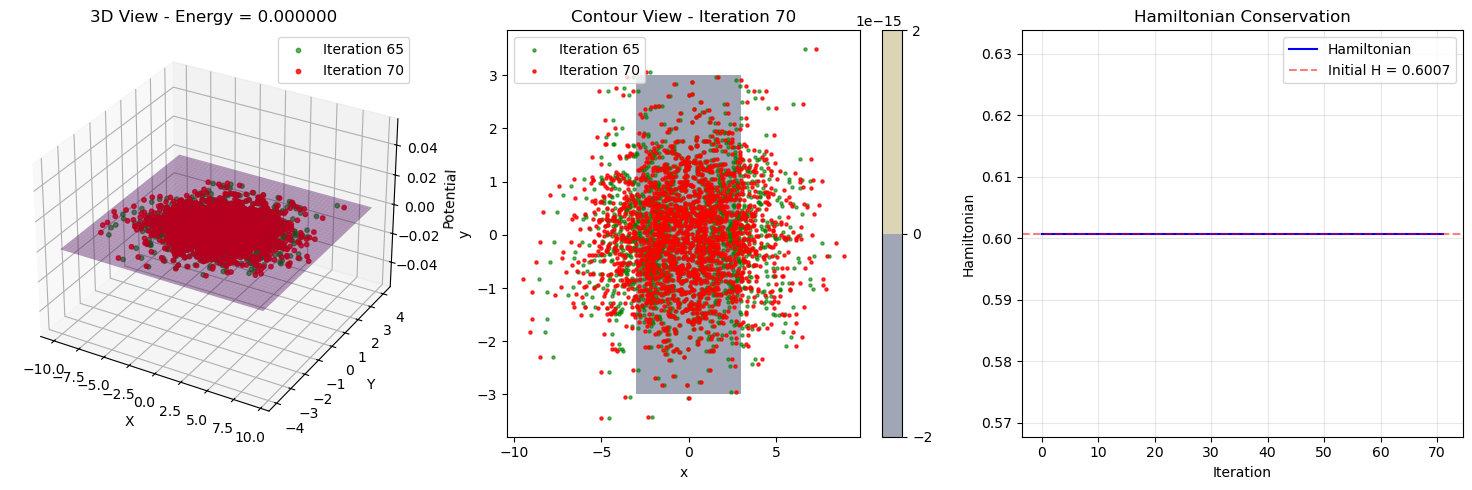

Hamiltonian Flow Progress:  72%|███████▏  | 71/99 [00:54<00:25,  1.08it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.051408]

Excellent Hamiltonian conservation at iteration 70


Hamiltonian Flow Progress:  73%|███████▎  | 72/99 [00:55<00:22,  1.22it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.057532]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 71


Hamiltonian Flow Progress:  74%|███████▎  | 73/99 [00:55<00:19,  1.36it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053629]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 72


Hamiltonian Flow Progress:  75%|███████▍  | 74/99 [00:56<00:17,  1.47it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054925]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 73


Hamiltonian Flow Progress:  76%|███████▌  | 75/99 [00:56<00:15,  1.56it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.057889]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 74


Hamiltonian Flow Progress:  76%|███████▌  | 75/99 [00:57<00:15,  1.56it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055827]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-7.7598169e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-3.1391251e+00,  6.2480410e-07],
                 [ 1.2155472e-01,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  75: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.22e-01


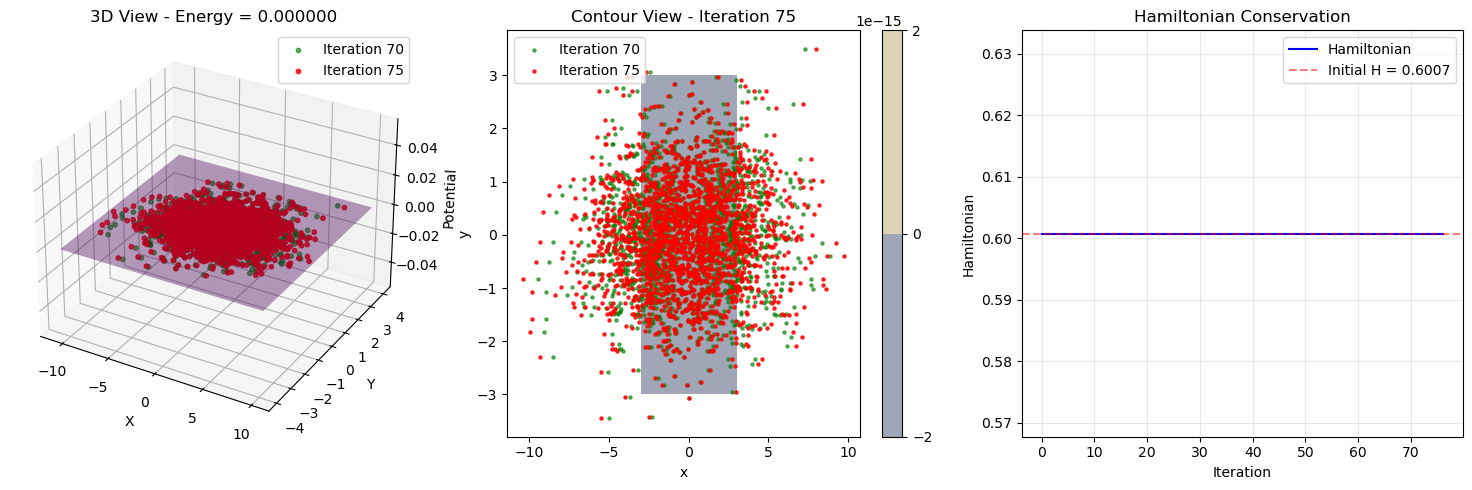

Hamiltonian Flow Progress:  77%|███████▋  | 76/99 [00:58<00:21,  1.09it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055827]

Excellent Hamiltonian conservation at iteration 75


Hamiltonian Flow Progress:  78%|███████▊  | 77/99 [00:58<00:17,  1.24it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.057625]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 76


Hamiltonian Flow Progress:  79%|███████▉  | 78/99 [00:59<00:15,  1.36it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053296]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 77


Hamiltonian Flow Progress:  80%|███████▉  | 79/99 [00:59<00:13,  1.47it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.052636]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 78


Hamiltonian Flow Progress:  81%|████████  | 80/99 [01:00<00:12,  1.56it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055054]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 79


Hamiltonian Flow Progress:  81%|████████  | 80/99 [01:01<00:12,  1.56it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.057144]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-8.1321575e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-3.4144058e+00,  6.2480410e-07],
                 [ 1.3502026e-01,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  80: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.19e-01


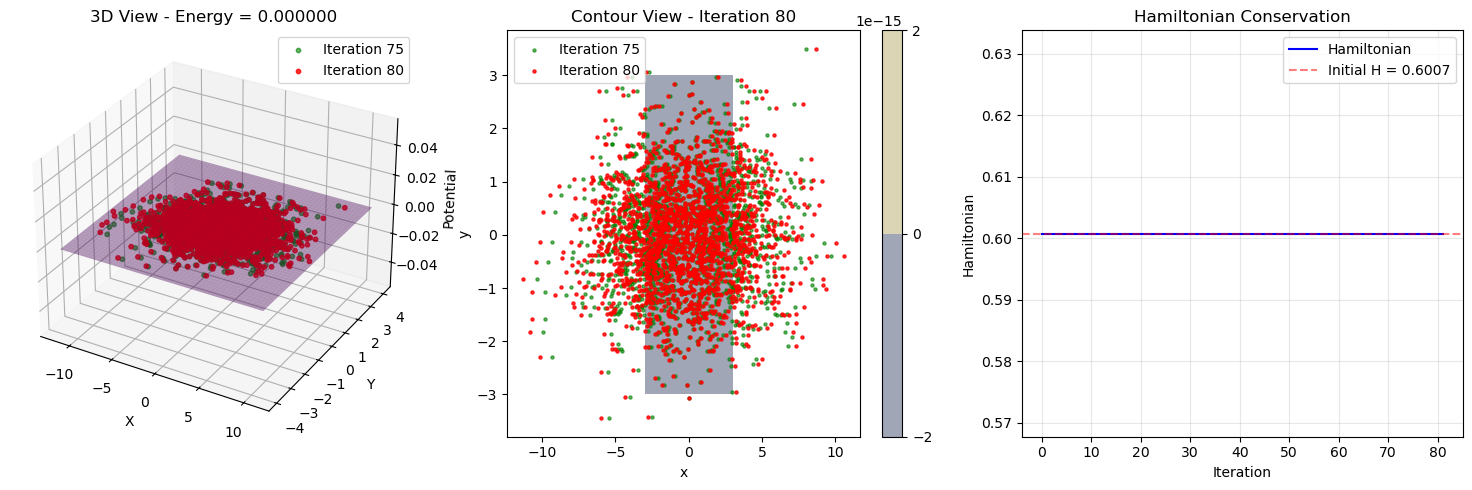

Hamiltonian Flow Progress:  82%|████████▏ | 81/99 [01:02<00:16,  1.09it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.057144]

Excellent Hamiltonian conservation at iteration 80


Hamiltonian Flow Progress:  83%|████████▎ | 82/99 [01:02<00:13,  1.23it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055123]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 81


Hamiltonian Flow Progress:  84%|████████▍ | 83/99 [01:03<00:11,  1.35it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054511]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 82


Hamiltonian Flow Progress:  85%|████████▍ | 84/99 [01:03<00:10,  1.46it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.052302]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 83


Hamiltonian Flow Progress:  86%|████████▌ | 85/99 [01:04<00:09,  1.55it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054497]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 84


Hamiltonian Flow Progress:  86%|████████▌ | 85/99 [01:04<00:09,  1.55it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054866]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-8.7879419e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-3.6854136e+00,  6.2480410e-07],
                 [ 1.4187405e-01,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  85: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.16e-01


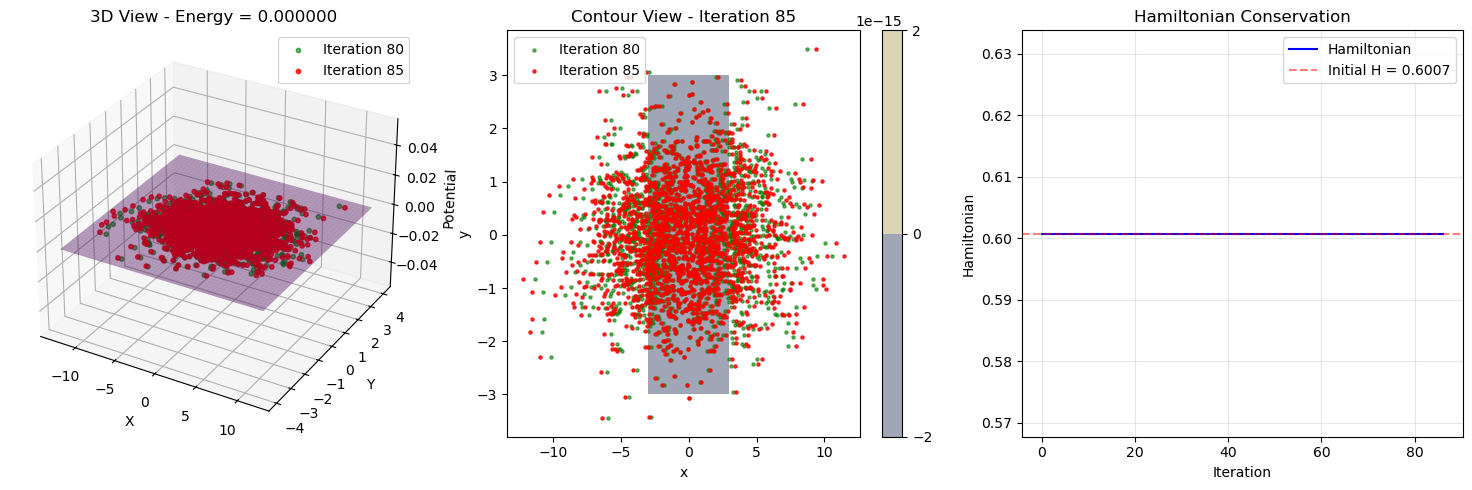

Hamiltonian Flow Progress:  87%|████████▋ | 86/99 [01:05<00:11,  1.09it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054866]

Excellent Hamiltonian conservation at iteration 85


Hamiltonian Flow Progress:  88%|████████▊ | 87/99 [01:06<00:09,  1.23it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053007]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 86


Hamiltonian Flow Progress:  89%|████████▉ | 88/99 [01:06<00:08,  1.36it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054438]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 87


Hamiltonian Flow Progress:  90%|████████▉ | 89/99 [01:07<00:06,  1.47it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054523]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 88


Hamiltonian Flow Progress:  91%|█████████ | 90/99 [01:08<00:05,  1.55it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055081]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 89


Hamiltonian Flow Progress:  91%|█████████ | 90/99 [01:08<00:05,  1.55it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.050763]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-9.0585344e-02,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-3.9530318e+00,  6.2480410e-07],
                 [ 1.5020826e-01,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  90: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.13e-01


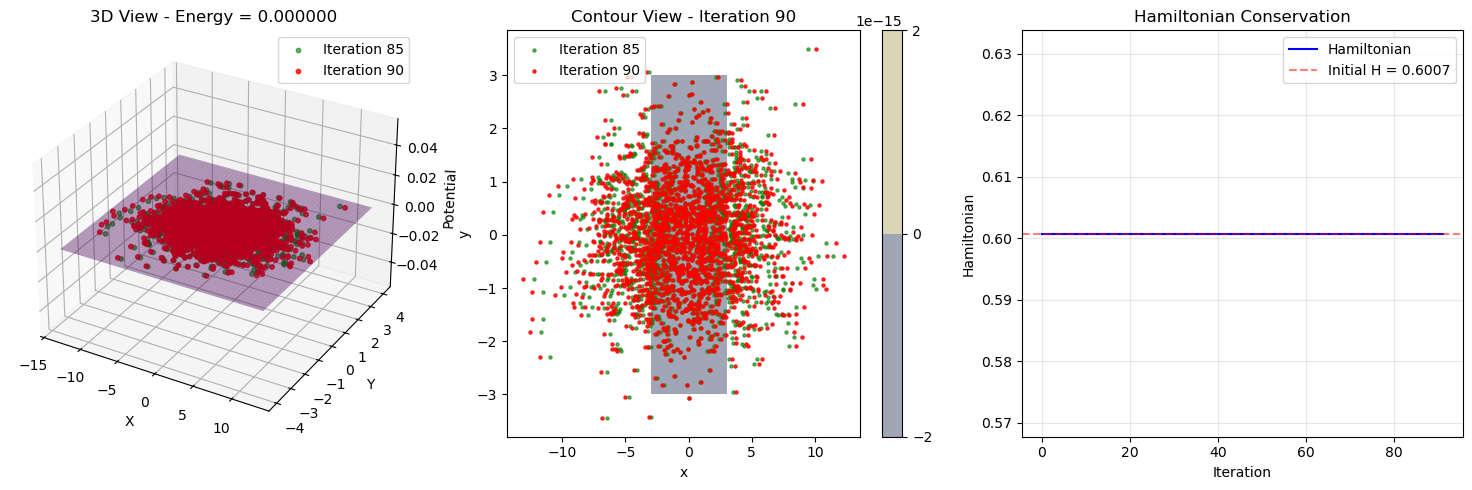

Hamiltonian Flow Progress:  92%|█████████▏| 91/99 [01:09<00:07,  1.09it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.050763]

Excellent Hamiltonian conservation at iteration 90


Hamiltonian Flow Progress:  93%|█████████▎| 92/99 [01:10<00:05,  1.23it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055304]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 91


Hamiltonian Flow Progress:  94%|█████████▍| 93/99 [01:10<00:04,  1.35it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055638]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 92


Hamiltonian Flow Progress:  95%|█████████▍| 94/99 [01:11<00:03,  1.46it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054381]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 93


Hamiltonian Flow Progress:  96%|█████████▌| 95/99 [01:11<00:02,  1.54it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054581]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 94


Hamiltonian Flow Progress:  96%|█████████▌| 95/99 [01:12<00:02,  1.54it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053634]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-1.0183443e-01,  1.3550105e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-4.2262297e+00,  6.2480410e-07],
                 [ 1.5599978e-01,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  95: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 2.18e-01


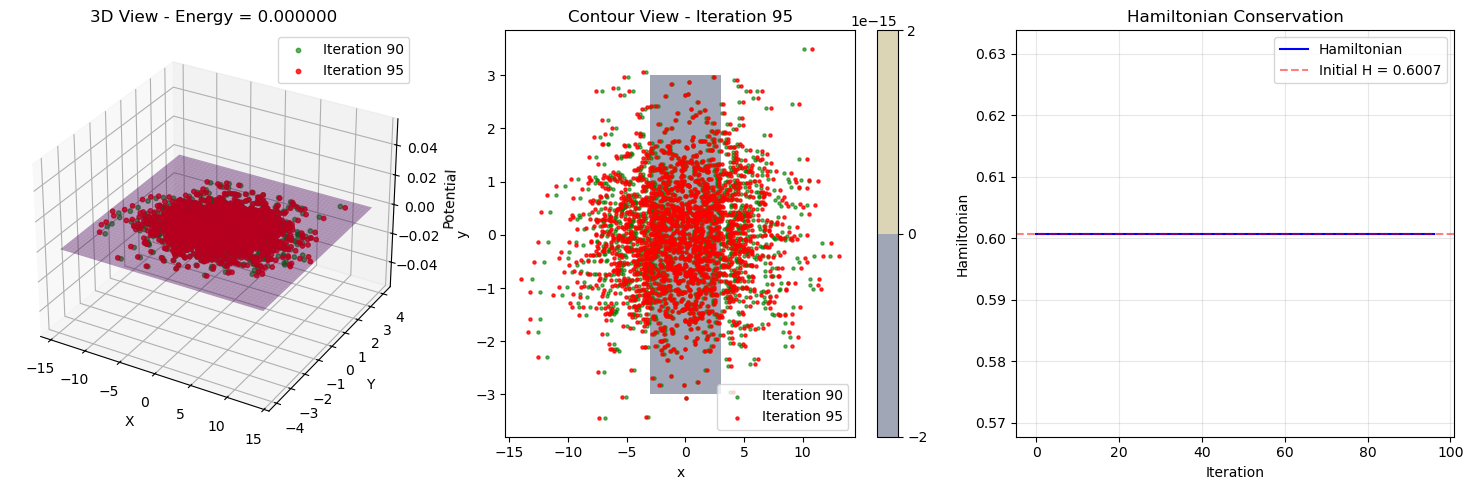

Hamiltonian Flow Progress:  97%|█████████▋| 96/99 [01:14<00:03,  1.11s/it, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.053634]

Excellent Hamiltonian conservation at iteration 95


Hamiltonian Flow Progress:  98%|█████████▊| 97/99 [01:14<00:01,  1.04it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054546]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 96


Hamiltonian Flow Progress:  99%|█████████▉| 98/99 [01:15<00:00,  1.18it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.054044]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
Excellent Hamiltonian conservation at iteration 97


Hamiltonian Flow Progress:  99%|█████████▉| 98/99 [01:15<00:00,  1.18it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055396]

Potential Energy: 0.0, Kinetic Energy: 0.6007452607154846
State({
  'model': {
    'layers': {
      0: {
        'bias': VariableState( # 2 (8 B)
          type=Param,
          value=Array([-1.00749284e-01,  1.35501045e-06], dtype=float32)
        ),
        'kernel': VariableState( # 4 (16 B)
          type=Param,
          value=Array([[-4.3900681e+00,  6.2480410e-07],
                 [ 1.6137594e-01,  9.9999917e-01]], dtype=float32)
        )
      }
    }
  }
})
Iter  98: Energy = 0.000000, Hamiltonian = 0.600745, H_drift = 0.00e+00, Avg_Displacement = 1.30e-01


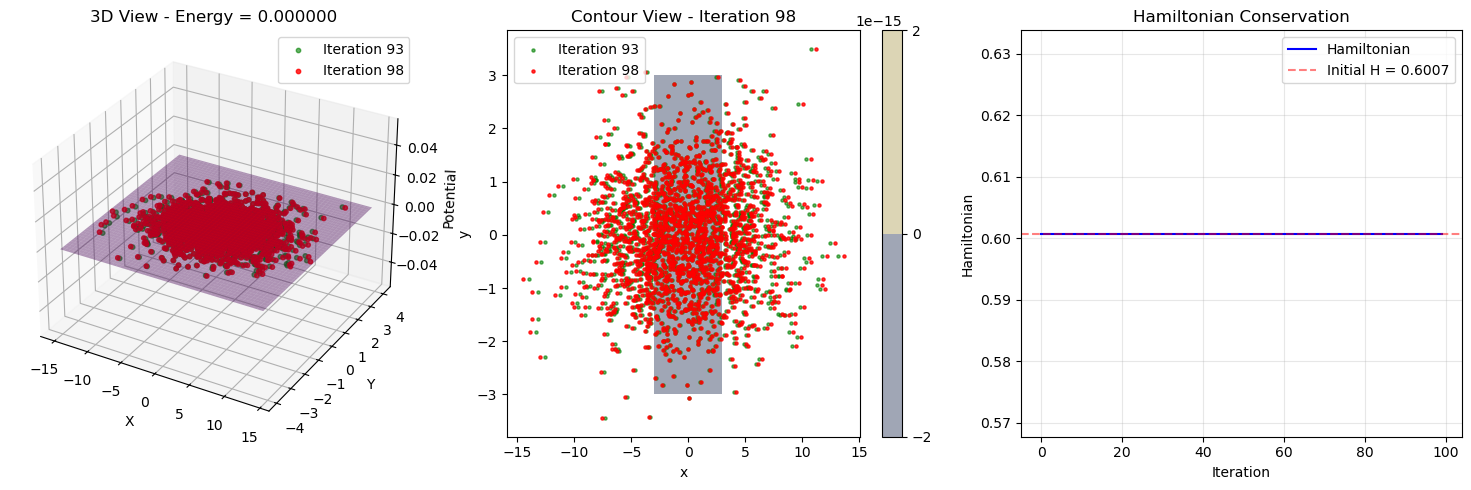

Hamiltonian Flow Progress: 100%|██████████| 99/99 [01:16<00:00,  1.29it/s, Energy=0.000000, Hamiltonian=0.600745, H_drift=0.00e+00, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1.086640, ||delta theta||=0.055396]

Excellent Hamiltonian conservation at iteration 98

=== Hamiltonian Integration Complete ===
Total iterations:         99
Initial Hamiltonian:      0.600745
Final Hamiltonian:        0.600745
Total Hamiltonian drift:  0.00e+00
Relative drift:           0.00e+00
Final energy:             0.000000
Final momentum norm:      1.086640
Final param norm:         4.506538


In [30]:
results = run_hamiltonian_flow(
    parametric_model=parametric_model,
    batch_size=n_samples,
    test_data_set=test_data_set,
    G_mat=G_mat,
    potential=potential,
    phi_fn=phi_fn,
    max_iterations=100,
    n_iters=10,
    h=step_size,
    solver=solver,
    progress_every=5,
    solver_maxiter=10,
    gamma=gamma,
    regularization=1e-3
)